# Random forest for time series data

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("NYSE.csv")

Dataset:  NYSE dataset. 

Only 3 time series in this dataset will be use: DJ_return ( 𝑎𝑡 ), log_volatility ( 𝑏𝑡 ), and log_volume ( 𝑐𝑡 ).

The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset here, which explains the meaning of the variables.

GOAL:

You want to predict the 1-step ahead value of log_volume  𝑐𝑡+1  using the previous values of this variable and the other two variables (DJ_return and log_volatility) up to 5 lags. So the features are  𝑐𝑡,…,𝑐𝑡−4,𝑏𝑡,…,𝑏𝑡−4,𝑎𝑡,…,𝑎𝑡−4 .

In [3]:
import numpy as np
import pandas as pd
data.head(10)

,date,day_of_week,DJ_return,log_volume,log_volatility,train
0,1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1,1962-12-04,tues,0.007813,0.346202,-11.749305,True
2,1962-12-05,wed,0.003845,0.525306,-11.665609,True
3,1962-12-06,thur,-0.003462,0.210182,-11.626772,True
4,1962-12-07,fri,0.000568,0.044187,-11.728130,True
5,1962-12-10,mon,-0.010824,0.133246,-10.872526,True
6,1962-12-11,tues,0.000124,-0.011528,-10.977797,True
7,1962-12-12,wed,0.003358,0.001607,-11.012360,True
8,1962-12-13,thur,-0.003296,-0.106437,-11.047108,True
9,1962-12-14,fri,0.004469,-0.138269,-11.022063,True


In [4]:
# creating cross-sectional data using time series data 
def ts_split(ts, feature_steps=5, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

DJ_return = ts_split(data['DJ_return'])[0]
log_volatility = ts_split(data['log_volatility'])[0]
log_volume, y = ts_split(data['log_volume'])

X =  np.hstack((log_volume, DJ_return, log_volatility))

In [5]:
print(X[:5])
print(y[:5])
X.shape

[[ 3.25730000e-02  3.46202000e-01  5.25306000e-01  2.10182000e-01
   4.41870000e-02 -4.46100000e-03  7.81300000e-03  3.84500000e-03
  -3.46200000e-03  5.68000000e-04 -1.31274026e+01 -1.17493047e+01
  -1.16656090e+01 -1.16267724e+01 -1.17281302e+01]
 [ 3.46202000e-01  5.25306000e-01  2.10182000e-01  4.41870000e-02
   1.33246000e-01  7.81300000e-03  3.84500000e-03 -3.46200000e-03
   5.68000000e-04 -1.08240000e-02 -1.17493047e+01 -1.16656090e+01
  -1.16267724e+01 -1.17281302e+01 -1.08725263e+01]
 [ 5.25306000e-01  2.10182000e-01  4.41870000e-02  1.33246000e-01
  -1.15280000e-02  3.84500000e-03 -3.46200000e-03  5.68000000e-04
  -1.08240000e-02  1.24000000e-04 -1.16656090e+01 -1.16267724e+01
  -1.17281302e+01 -1.08725263e+01 -1.09777968e+01]
 [ 2.10182000e-01  4.41870000e-02  1.33246000e-01 -1.15280000e-02
   1.60700000e-03 -3.46200000e-03  5.68000000e-04 -1.08240000e-02
   1.24000000e-04  3.35800000e-03 -1.16267724e+01 -1.17281302e+01
  -1.08725263e+01 -1.09777968e+01 -1.10123599e+01]
 [ 4

(6046, 15)

Fitting a random forest to predict the 1-step ahead value of log_volume. 

Using 3-fold time series CV, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters n_estimators taking the values 100, 500, 750, and the cost-complexity pruning parameter  𝛼  taking the values  10−𝑘 ,  𝑘=0,1,…,9 . The performance measure is RMSE. 



In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

ccp_alpha_list= []

for i in range(10):
    ccp_alpha_list.append(10**-i)

n_estimators_list = [100, 500, 750]


def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    series_len = X.shape[0] 

    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            for n_estimators in n_estimators_list:
                for alpha in ccp_alpha_list:
                    model_rf = RandomForestRegressor(random_state=42,n_estimators=n_estimators,
                                                     ccp_alpha = alpha,n_jobs=-1)
                    model_rf.fit(X_train, y_train.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
        
        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, 
                       ccp_alpha=optimal_par[0], n_estimators=optimal_par[1],n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))
            
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="1-steps ahead prediction")
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, label="True value")
                plt.legend(loc="upper left")
    
    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(ccp_alpha_list)*len(n_estimators_list)), axis=0)
        return rf_rmse
    
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        return rf_rmse, y_test_rf          

In [7]:
from sklearn.metrics import mean_squared_error

rf_rmse = time_series_valid_test(X, y, 3, "valid")
ind = 0
rmse_arr = []
for n_estimators in n_estimators_list:
    for alpha in ccp_alpha_list:
        print(["(alpha, n_estimators):",[alpha, n_estimators]])
        rmse_arr.append(rf_rmse[ind])
        print("Model-",ind+1,"rmse: ",rf_rmse[ind])
        
        ind += 1


['(alpha, n_estimators):', [1, 100]]
Model- 1 rmse:  0.2358102502325389
['(alpha, n_estimators):', [0.1, 100]]
Model- 2 rmse:  0.2358102502325389
['(alpha, n_estimators):', [0.01, 100]]
Model- 3 rmse:  0.1931776501341703
['(alpha, n_estimators):', [0.001, 100]]
Model- 4 rmse:  0.1742571823815323
['(alpha, n_estimators):', [0.0001, 100]]
Model- 5 rmse:  0.1614501523436291
['(alpha, n_estimators):', [1e-05, 100]]
Model- 6 rmse:  0.1609221218344437
['(alpha, n_estimators):', [1e-06, 100]]
Model- 7 rmse:  0.1612690171345897
['(alpha, n_estimators):', [1e-07, 100]]
Model- 8 rmse:  0.16132852989129298
['(alpha, n_estimators):', [1e-08, 100]]
Model- 9 rmse:  0.16134226586644118
['(alpha, n_estimators):', [1e-09, 100]]
Model- 10 rmse:  0.1613426447569936
['(alpha, n_estimators):', [1, 500]]
Model- 11 rmse:  0.23583279057420017
['(alpha, n_estimators):', [0.1, 500]]
Model- 12 rmse:  0.23583279057420017
['(alpha, n_estimators):', [0.01, 500]]
Model- 13 rmse:  0.19289278821198516
['(alpha, n_esti

In [8]:
min_value = min(rmse_arr)
min_index=rmse_arr.index(min_value)
min_index+1

print(f'Min value of rmse = {min_value} \nBest Hyperparameters: ccp_aplha = 10^-5 , n_estimator = 500')

Min value of rmse = 0.1603712805479507 
Best Hyperparameters: ccp_aplha = 10^-5 , n_estimator = 500


RMSE of the best fitting model on the test set

plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV

0.18695778279368594

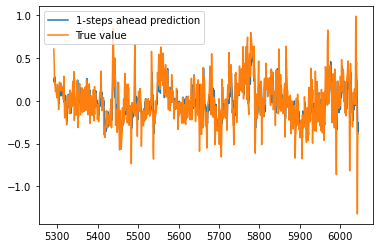

In [9]:
rf_rmse, y_test_rf = time_series_valid_test(X, y, 3, "test", [10**-5, 500])
rf_rmse


It is often useful to check that your model is not worse than a very simple method of prediction. Compute the RMSE of a model that simply predicts the 1-step ahead value of log_volume  𝑐𝑡+1  as the current value  𝑐𝑡 , and compare this to the best fitting random forest model.

In [10]:
y_simple = data['log_volume'][:-1]
y_simple_pred = data['log_volume'][1:]
rmse_simple = np.sqrt(mean_squared_error(y_simple, y_simple_pred))
rmse_simple

0.18890174010847652

In [11]:
print("Simple Predictor works better than Random Forest") if rmse_simple < rf_rmse else print("Random Forest works better than Simple Predictor")

Random Forest works better than Simple Predictor


Computing the feature importances of the best fitting model.

In [12]:
best_model = RandomForestRegressor(n_estimators=500, ccp_alpha=10**(-5), n_jobs=-1, random_state=42)
best_model.fit(X, y.ravel())

feat_imp = best_model.feature_importances_
val = max(best_model.feature_importances_)
index, = np.where(feat_imp == val)
print("most important feature is current log_volume c(t)): ", index+1 ,"\nfeature importance value: ", val)

most important feature is current log_volume c(t)):  [5] 
feature importance value:  0.5284543420578321
